In [ ]:
import panel as pn
pn.extension("mathjax", "katex", "ipywidgets")

pn.panel("Hello World").servable()

In [1]:
from pathlib import Path
from typing import Any, Dict
import numpy as np
import numpy.typing as npt
import pandas as pd
from lmfit import Parameters
from echopop import inversion
from echopop.nwfsc_feat import (
    # apportion,
    biology, 
    FEAT,
    ingest_nasc, 
    get_proportions, 
    kriging,
    load_data, 
    # mesh,
    spatial,
    transect, 
    utils,
    variogram
)
# ==================================================================================================
# ==================================================================================================
# DEFINE DATA ROOT DIRECTORY
# --------------------------
# DATA_ROOT = Path("C:/Users/Brandyn/Documents/GitHub/EchoPro_data/echopop_2019")
DATA_ROOT = Path("C:/Users/Brandyn Lucca/Documents/Data/echopop_2019/")

# ==================================================================================================
# ==================================================================================================
# DATA INGESTION
# ==================================================================================================
# Organize NASC file
# ------------------

# Merge exports
df_intervals, df_exports = ingest_nasc.merge_echoview_nasc(
    nasc_path = DATA_ROOT / "raw_nasc/",
    filename_transect_pattern = r"T(\d+)",
    default_transect_spacing = 10.0,
    default_latitude_threshold = 60.0,
)

# ==================================================================================================
# Read in transect-region-haul keys
# ---------------------------------
TRANSECT_REGION_FILEPATH_ALL_AGES: Path = Path(
    DATA_ROOT / "Stratification/US_CAN_2019_transect_region_haul_age1+ auto_final.xlsx"
)
TRANSECT_REGION_SHEETNAME_ALL_AGES: str = "Sheet1"
TRANSECT_REGION_FILEPATH_NO_AGE1: Path = Path(
    DATA_ROOT / "Stratification/US_CAN_2019_transect_region_haul_age2+ auto_20191205.xlsx"
)
TRANSECT_REGION_SHEETNAME_NO_AGE1: str = "Sheet1"
TRANSECT_REGION_FILE_RENAME: dict = {
    "tranect": "transect_num",
    "region id": "region_id",
    "trawl #": "haul_num",
}

# Read in the transect-region-haul key files for each group
transect_region_haul_key_all_ages: pd.DataFrame = ingest_nasc.read_transect_region_haul_key(
    filename=TRANSECT_REGION_FILEPATH_ALL_AGES,
    sheetname=TRANSECT_REGION_SHEETNAME_ALL_AGES,
    rename_dict=TRANSECT_REGION_FILE_RENAME,
)

transect_region_haul_key_no_age1: pd.DataFrame = ingest_nasc.read_transect_region_haul_key(
    TRANSECT_REGION_FILEPATH_NO_AGE1, TRANSECT_REGION_SHEETNAME_NO_AGE1, TRANSECT_REGION_FILE_RENAME
)

# ==================================================================================================
# Read in transect-region-haul keys
# ---------------------------------
REGION_NAME_EXPR_DICT: Dict[str, dict] = {
    "REGION_CLASS": {
        "Age-1 Hake": "^(?:h1a(?![a-z]|m))",
        "Age-1 Hake Mix": "^(?:h1am(?![a-z]|1a))",
        "Hake": "^(?:h(?![a-z]|1a)|hake(?![_]))",
        "Hake Mix": "^(?:hm(?![a-z]|1a)|hake_mix(?![_]))",
    },
    "HAUL_NUM": {
        "[0-9]+",
    },
    "COUNTRY": {
        "CAN": "^[cC]",
        "US": "^[uU]",
    },
}

# Process the region name codes to define the region classes
# e.g. H5C - Region 2 corresponds to "Hake, Haul #5, Canada"
df_exports_with_regions: pd.DataFrame = ingest_nasc.process_region_names(
    df=df_exports,
    region_name_expr_dict=REGION_NAME_EXPR_DICT,
    can_haul_offset=200,
)

# ==================================================================================================
# [OPTIONAL] Generate transect-region-haul key from compiled values
# ---------------------------------

# Generate transect-region-haul key from compiled values
df_transect_region_haul_key_no_age1: pd.DataFrame = ingest_nasc.generate_transect_region_haul_key(
    df=df_exports_with_regions, 
    filter_list=["Hake", "Hake Mix"]
)

df_transect_region_haul_key_all_ages = ingest_nasc.generate_transect_region_haul_key(
    df=df_exports_with_regions, 
    filter_list=["Age-1 Hake", "Age-1", "Hake", "Hake Mix"]
)

# ==================================================================================================
# Consolidate the Echvoiew NASC export files
# ------------------------------------------
df_nasc_no_age1: pd.DataFrame = ingest_nasc.consolidate_echvoiew_nasc(
    df_merged=df_exports_with_regions,
    interval_df=df_intervals,
    region_class_names=["Hake", "Hake Mix"],
    impute_region_ids=True,
    transect_region_haul_key_df=transect_region_haul_key_no_age1,
)

df_nasc_all_ages: pd.DataFrame = ingest_nasc.consolidate_echvoiew_nasc(
    df_merged=df_exports_with_regions,
    interval_df=df_intervals,
    region_class_names=["Age-1 Hake", "Age-1", "Hake", "Hake Mix"],
    impute_region_ids=True,
    transect_region_haul_key_df=transect_region_haul_key_all_ages,
)

# ==================================================================================================
# [OPTIONAL] Read in a pre-consolidated NASC data file
# ----------------------------------------------------
FEAT_TO_ECHOPOP_COLUMNS: Dict[str, str] = {
    "transect": "transect_num",
    "region id": "region_id",
    "vessel_log_start": "distance_s",
    "vessel_log_end": "distance_e",
    "spacing": "transect_spacing",
    "layer mean depth": "layer_mean_depth",
    "layer height": "layer_height",
    "bottom depth": "bottom_depth",
    "assigned haul": "haul_num",
}

#
df_nasc_all_ages: pd.DataFrame = ingest_nasc.read_nasc_file(
    filename=DATA_ROOT / "Exports/US_CAN_NASC_2019_table_all_ages.xlsx",
    sheetname="Sheet1",
    column_name_map=FEAT_TO_ECHOPOP_COLUMNS,
)
# ==================================================================================================
# Load in the biolodical data
# ---------------------------
BIODATA_SHEET_MAP: Dict[str, str] = {
    "catch": "biodata_catch", 
    "length": "biodata_length",
    "specimen": "biodata_specimen",
}
SUBSET_DICT: Dict[Any, Any] = {
    "ships": {
        160: {
            "survey": 201906
        },
        584: {
            "survey": 2019097,
            "haul_offset": 200
        }
    },
    "species_code": [22500]
}
FEAT_TO_ECHOPOP_BIODATA_COLUMNS = {
    "frequency": "length_count",
    "haul": "haul_num",
    "weight_in_haul": "weight",
}
BIODATA_LABEL_MAP: Dict[Any, Dict] = {
    "sex": {
        1: "male",
        2: "female",
        3: "unsexed"
    }
}

# 
dict_df_bio = load_data.load_biological_data(
    biodata_filepath=DATA_ROOT / "Biological/1995-2023_biodata_redo.xlsx", 
    biodata_sheet_map=BIODATA_SHEET_MAP, 
    column_name_map=FEAT_TO_ECHOPOP_BIODATA_COLUMNS, 
    subset_dict=SUBSET_DICT, 
    biodata_label_map=BIODATA_LABEL_MAP
)

# ==================================================================================================
# Load in strata files
# --------------------
STRATA_SHEET_MAP = {
    "inpfc": "INPFC",
    "ks": "Base KS",
}
FEAT_TO_ECHOPOP_STRATA_COLUMNS = {
    "fraction_hake": "nasc_proportion",
    "haul": "haul_num",
    "stratum": "stratum_num",
}

#
df_dict_strata = load_data.load_strata(
    strata_filepath=DATA_ROOT / "Stratification/US_CAN strata 2019_final.xlsx", 
    strata_sheet_map=STRATA_SHEET_MAP, 
    column_name_map=FEAT_TO_ECHOPOP_STRATA_COLUMNS
)

# ==================================================================================================
# Load in geographical strata files
# ---------------------------------
GEOSTRATA_SHEET_MAP = {
    "inpfc": "INPFC",
    "ks": "stratification1",
}
FEAT_TO_ECHOPOP_GEOSTRATA_COLUMNS = {
    "latitude (upper limit)": "northlimit_latitude",
    "stratum": "stratum_num",
}

# 
df_dict_geostrata = load_data.load_geostrata(
    geostrata_filepath=DATA_ROOT / "Stratification/Stratification_geographic_Lat_2019_final.xlsx", 
    geostrata_sheet_map=GEOSTRATA_SHEET_MAP, 
    column_name_map=FEAT_TO_ECHOPOP_GEOSTRATA_COLUMNS
)

# ==================================================================================================
# Stratify data based on haul numbers
# -----------------------------------

# Add INPFC
# ---- NASC
df_nasc_all_ages = load_data.join_strata_by_haul(data=df_nasc_all_ages, 
                                                 strata_df=df_dict_strata["inpfc"],
                                                 stratum_name="stratum_inpfc") 
# ---- Biodata
dict_df_bio = load_data.join_strata_by_haul(dict_df_bio,
                                            df_dict_strata["inpfc"],
                                            stratum_name="stratum_inpfc")

# Add KS
# ---- NASC
df_nasc_all_ages = load_data.join_strata_by_haul(df_nasc_all_ages, 
                                                 df_dict_strata["ks"],
                                                 stratum_name="stratum_ks") 
df_nasc_no_age1 = load_data.join_strata_by_haul(df_nasc_no_age1, 
                                                df_dict_strata["ks"],
                                                stratum_name="stratum_ks") 
# ---- Biodata
dict_df_bio = load_data.join_strata_by_haul(dict_df_bio,
                                            df_dict_strata["ks"],
                                            stratum_name="stratum_ks") 

# ==================================================================================================
# Load kriging mesh file
# ----------------------

FEAT_TO_ECHOPOP_MESH_COLUMNS = {
    "centroid_latitude": "latitude",
    "centroid_longitude": "longitude",
    "fraction_cell_in_polygon": "fraction",
}

# 
df_mesh = load_data.load_mesh_data(
    mesh_filepath=DATA_ROOT / "Kriging_files/Kriging_grid_files/krig_grid2_5nm_cut_centroids_2013.xlsx", 
    sheet_name="krigedgrid2_5nm_forChu", 
    column_name_map=FEAT_TO_ECHOPOP_MESH_COLUMNS
)

# ==================================================================================================
# [OPTIONAL] Stratify data based on latitude intervals
# ----------------------------------------------------
# INPFC (from geostrata)
df_nasc_all_ages = load_data.join_geostrata_by_latitude(df_nasc_all_ages, 
                                                        df_dict_geostrata["inpfc"],
                                                        stratum_name="geostratum_inpfc")
# KS (from geostrata)
df_nasc_all_ages = load_data.join_geostrata_by_latitude(df_nasc_all_ages, 
                                                        df_dict_geostrata["ks"],
                                                        stratum_name="geostratum_ks")

# MESH
# ---- DataFrame merged with geographically distributed stratum number (KS or INPFC)
# -------- INPFC (from geostrata)
df_mesh = load_data.join_geostrata_by_latitude(df_mesh, 
                                               df_dict_geostrata["inpfc"], 
                                               stratum_name="geostratum_inpfc")
# -------- KS (from geostrata)
df_mesh = load_data.join_geostrata_by_latitude(df_mesh, 
                                               df_dict_geostrata["ks"], 
                                               stratum_name="geostratum_ks")

# ==================================================================================================
# Load kriging and variogram parameters
# -------------------------------------

FEAT_TO_ECHOPOP_GEOSTATS_PARAMS_COLUMNS = {
    "hole": "hole_effect_range",
    "lscl": "correlation_range",
    "nugt": "nugget",
    "powr": "decay_power",
    "ratio": "aspect_ratio",
    "res": "lag_resolution",
    "srad": "search_radius",
}

# 
dict_kriging_params, dict_variogram_params = load_data.load_kriging_variogram_params(
    geostatistic_params_filepath=(
        DATA_ROOT / "Kriging_files/default_vario_krig_settings_2019_US_CAN.xlsx"
    ),
    sheet_name="Sheet1",
    column_name_map=FEAT_TO_ECHOPOP_GEOSTATS_PARAMS_COLUMNS
)

# ==================================================================================================
# ==================================================================================================
# DATA PROCESSING
# ==================================================================================================
# Generate binned distributions [age, length]
# -------------------------------------------
AGE_BINS: npt.NDArray[np.number] = np.linspace(start=1., stop=22., num=22)
LENGTH_BINS: npt.NDArray[np.number] = np.linspace(start=2., stop=80., num=40)

# 
# ---- Length
utils.binify(
    data=dict_df_bio, bins=LENGTH_BINS, bin_column="length", 
)

# Age
utils.binify(
    data=dict_df_bio, bins=AGE_BINS, bin_column="age",
)

# ==================================================================================================
# Fit length-weight regression to the binned data
# -----------------------------------------------

# Dictionary for length-weight regression coefficients
dict_length_weight_coefs = {}

# For all fish
dict_length_weight_coefs["all"] = dict_df_bio["specimen"].assign(sex="all").groupby(["sex"]).apply(
    biology.fit_length_weight_regression,
    include_groups=False
)

# Sex-specific
dict_length_weight_coefs["sex"] = dict_df_bio["specimen"].groupby(["sex"]).apply(
    biology.fit_length_weight_regression,
    include_groups=False
)

# ==================================================================================================
# Compute the mean weights per length bin
# ---------------------------------------

# Sex-specific (grouped coefficients)
df_binned_weights_sex = biology.length_binned_weights(
    data=dict_df_bio["specimen"],
    length_bins=LENGTH_BINS,
    regression_coefficients=dict_length_weight_coefs["sex"],
    impute_bins=True,
    minimum_count_threshold=5
)

# All fish (single coefficient set)
df_binned_weights_all = biology.length_binned_weights(
    data=dict_df_bio["specimen"].assign(sex="all"),
    length_bins=LENGTH_BINS,
    regression_coefficients=dict_length_weight_coefs["all"],
    impute_bins=True,
    minimum_count_threshold=5,
)

# Combine the pivot tables by adding the "all" column to the sex-specific table
binned_weight_table = pd.concat([df_binned_weights_sex, df_binned_weights_all], axis=1)

# ==================================================================================================
# Compute the count distributions per age- and length-bins
# --------------------------------------------------------

# Dictionary for number counts
dict_df_counts = {}

# Aged
dict_df_counts["aged"] = get_proportions.compute_binned_counts(
    data=dict_df_bio["specimen"].dropna(subset=["age", "length", "weight"]), 
    groupby_cols=["stratum_ks", "length_bin", "age_bin", "sex"], 
    count_col="length",
    agg_func="size"
)

# Unaged
dict_df_counts["unaged"] = get_proportions.compute_binned_counts(
    data=dict_df_bio["length"].copy().dropna(subset=["length"]), 
    groupby_cols=["stratum_ks", "length_bin", "sex"], 
    count_col="length_count",
    agg_func="sum"
)

# ==================================================================================================
# Compute the number proportions
# ------------------------------
dict_df_number_proportion: Dict[str, pd.DataFrame] = get_proportions.number_proportions(
    data=dict_df_counts, 
    group_columns=["stratum_ks"],
    column_aliases=["aged", "unaged"],
    exclude_filters={"aged": {"sex": "unsexed"}},
)

# ==================================================================================================
# Distribute (bin) weight over age, length, and sex
# -------------------------------------------------
# Pre-allocate a dictionary
dict_df_weight_distr: Dict[str, Any] = {}

# Aged
dict_df_weight_distr["aged"] = get_proportions.binned_weights(
    length_dataset=dict_df_bio["specimen"],
    include_filter = {"sex": ["female", "male"]},
    interpolate_regression=False,
    contrast_vars="sex",
    table_cols=["stratum_ks", "sex", "age_bin"]
)

# Unaged
dict_df_weight_distr["unaged"] = get_proportions.binned_weights(
    length_dataset=dict_df_bio["length"],
    length_weight_dataset=binned_weight_table,
    include_filter = {"sex": ["female", "male"]},
    interpolate_regression=True,
    contrast_vars="sex",
    table_cols=["stratum_ks", "sex"]
)

# ==================================================================================================
# Calculate the average weights pre stratum when combining different datasets
# ---------------------------------------------------------------------------
df_averaged_weight = get_proportions.stratum_averaged_weight(
    proportions_dict=dict_df_number_proportion, 
    binned_weight_table=binned_weight_table,
    stratum_col="stratum_ks",
)

# ==================================================================================================
# Compute the length-binned weight proportions for aged fish
# ----------------------------------------------------------

# Initialize Dictionary container
dict_df_weight_proportion: Dict[str, Any] = {}

# Aged
dict_df_weight_proportion["aged"] = get_proportions.weight_proportions(
    weight_data=dict_df_weight_distr, 
    catch_data=dict_df_bio["catch"], 
    group="aged",
    stratum_col="stratum_ks"
)

# ==================================================================================================
# Compute the standardized haul weights for unaged fish
# -----------------------------------------------------

standardized_sexed_unaged_weights_df = get_proportions.scale_weights_by_stratum(
    weights_df=dict_df_weight_distr["unaged"], 
    reference_weights_df=dict_df_bio["catch"].groupby(["stratum_ks"])["weight"].sum(),
    stratum_col="stratum_ks",
)

# ==================================================================================================
# Compute the standardized weight proportionsfor unaged fish
# ----------------------------------------------------------

dict_df_weight_proportion["unaged"] = get_proportions.scale_weight_proportions(
    weight_data=standardized_sexed_unaged_weights_df, 
    reference_weight_proportions=dict_df_weight_proportion["aged"], 
    catch_data=dict_df_bio["catch"], 
    number_proportions=dict_df_number_proportion,
    binned_weights=binned_weight_table["all"],
    group="unaged",
    group_columns = ["sex"],
    stratum_col = "stratum_ks"
)
# ==================================================================================================
# ==================================================================================================
# NASC TO POPULATION ESTIMATE CONVERSION
# ==================================================================================================
# Initialize the Inversion class
# ------------------------------
MODEL_PARAMETERS = {
    "ts_length_regression": {
        "slope": 20.,
        "intercept": -68.
    },
    "stratify_by": ["stratum_ks"],
    "expected_strata": df_dict_strata["ks"].stratum_num.unique(),
    "impute_missing_strata": True,
    "haul_replicates": True,
}

# Initiate object to perform inversion
invert_hake = inversion.InversionLengthTS(MODEL_PARAMETERS)

# ==================================================================================================
# Invert number density
# ---------------------

# If the above haul-averaged `sigma_bs` values were calculated, then the inversion can can 
# completed without calling in additional biodata
df_nasc_all_ages = invert_hake.invert(df_nasc=df_nasc_all_ages,
                                      df_length=[dict_df_bio["length"], dict_df_bio["specimen"]])
df_nasc_no_age1 = invert_hake.invert(df_nasc=df_nasc_no_age1,
                                     df_length=[dict_df_bio["length"], dict_df_bio["specimen"]])
# ---- The average `sigma_bs` for each stratum can be inspected at:
invert_hake.sigma_bs_strata

# ==================================================================================================
# Set transect interval distances
# -------------------------------

# Calculate along-transect interval distances which is required for getting the area-per-interval 
# and therefore going from number density to abundance
transect.set_interval_distance(df_nasc=df_nasc_all_ages, interval_threshold=0.05)
transect.set_interval_distance(df_nasc=df_nasc_no_age1, interval_threshold=0.05)

# ==================================================================================================
# Calculate transect interval areas
# ---------------------------------
df_nasc_all_ages["area_interval"] = (
    df_nasc_all_ages["transect_spacing"] * df_nasc_all_ages["distance_interval"]
)
df_nasc_no_age1["area_interval"] = (
    df_nasc_no_age1["transect_spacing"] * df_nasc_no_age1["distance_interval"]
)

# ==================================================================================================
# Calculate remaining population metrics across all animals 
# ---------------------------------------------------------
biology.set_population_metrics(df_nasc=df_nasc_all_ages, 
                               metrics=["abundance", "biomass", "biomass_density"],
                               stratify_by="stratum_ks",
                               df_average_weight=df_averaged_weight["all"])

biology.set_population_metrics(df_nasc=df_nasc_no_age1, 
                               metrics=["abundance", "biomass", "biomass_density"],
                               stratify_by="stratum_ks",
                               df_average_weight=df_averaged_weight["all"])

# ==================================================================================================
# Get proportions for each stratum specific to age-1
# --------------------------------------------------

# Age-1 NASC proportions
age1_nasc_proportions = get_proportions.get_nasc_proportions_slice(
    number_proportions=dict_df_number_proportion["aged"],
    stratify_by=["stratum_ks"],
    ts_length_regression_parameters={"slope": 20., 
                                     "intercept": -68.},
    include_filter = {"age_bin": [1]}
)

# Age-1 number proportions
age1_number_proportions = get_proportions.get_number_proportions_slice(
    number_proportions=dict_df_number_proportion["aged"],
    stratify_by=["stratum_ks"],
    include_filter = {"age_bin": [1]}
)

# Age-1 weight proportions
age1_weight_proportions = get_proportions.get_weight_proportions_slice(
    weight_proportions=dict_df_weight_proportion["aged"],
    stratify_by=["stratum_ks"],
    include_filter={"age_bin": [1]},
    number_proportions=dict_df_number_proportion,
    length_threshold_min=10.0,
    weight_proportion_threshold=1e-10
)

# ==================================================================================================
# ==================================================================================================
# GEOSTATISTICS
# ==================================================================================================
# Load reference line (isobath)
# -----------------------------

df_isobath = load_data.load_isobath_data(
    isobath_filepath=DATA_ROOT / "Kriging_files/Kriging_grid_files/transformation_isobath_coordinates.xlsx", 
    sheet_name="Smoothing_EasyKrig", 
)

# ==================================================================================================
# Transform the geospatial coordinates for the transect data
# ----------------------------------------------------------
df_nasc_no_age1, delta_longitude, delta_latitude = spatial.transform_coordinates(
    data = df_nasc_no_age1,
    reference = df_isobath,
    x_offset = -124.78338,
    y_offset = 45.,   
)

# ==================================================================================================
# Transform the geospatial coordinates for the mesh data
# ------------------------------------------------------
df_mesh, _, _ = spatial.transform_coordinates(
    data = df_mesh,
    reference = df_isobath,
    x_offset = -124.78338,
    y_offset = 45.,   
    delta_x=delta_longitude,
    delta_y=delta_latitude
)
# - 
# Map to the variogram function API
# - 
VARIOGRAM_MODEL_PARAMETER_MAP = {
    "Bessel-Exponential": ["bessel", "exponential"],
    "Bessel-Gaussian": ["bessel", "gaussian"],
    "Cosine-Exponential": ["cosine", "exponential"],
    "Cosine-Gaussian": ["cosine", "gaussian"],
    "Cubic": "cubic",
    "Exponential": "exponential",
    "Exponential-Linear": ["exponential", "linear"],
    "Gaussian": "gaussian",
    "Gaussian-Linear": ["gaussian", "linear"],
    "J-Bessel": "jbessel",
    "K-Bessel": "kbessel",
    "Linear": "linear",
    "Matérn": "matern",
    "Nugget": "nugget",
    "Pentaspherical": "pentaspherical",
    "Power law": "power",
    "Rational quadratic": "quadratic",
    "Cardinal sine": "sinc",
    "Spherical": "spherical",
}

# - 
# Map to the Variogram initialization
# - 
BASE_VARIOGRAM_PARAMETER_MAP = {
    "n_lags": dict(name="Number of lags", widget="entry", step=1, string_format="d"),
    "lag_resolution": dict(name="Lag resolution", widget="entry", step=1e-4, string_format="0.4f")
}

C:\Users\Brandyn Lucca\Documents\GitHub\echopop\echopop\nwfsc_feat\load_data.py:409: UserWarning: Dropping existing stratification columns {'nasc_proportion', 'year'} from the dataframe.
  warnings.warn(
C:\Users\Brandyn Lucca\Documents\GitHub\echopop\echopop\nwfsc_feat\load_data.py:409: UserWarning: Dropping existing stratification columns {'nasc_proportion', 'year'} from the dataframe.
  warnings.warn(
C:\Users\Brandyn Lucca\Documents\GitHub\echopop\echopop\nwfsc_feat\load_data.py:409: UserWarning: Dropping existing stratification columns {'nasc_proportion', 'year'} from the dataframe.
  warnings.warn(
C:\Users\Brandyn Lucca\Documents\GitHub\echopop\echopop\nwfsc_feat\load_data.py:409: UserWarning: Dropping existing stratification columns {'nasc_proportion', 'year'} from the dataframe.
  warnings.warn(


In [2]:
# Initialize
vgm = variogram.Variogram(
    lag_resolution=0.002,
    n_lags=30,
    coordinate_names=("x", "y"),
)

# ==================================================================================================
# Calculate the empirical variogram
# ---------------------------------
vgm.calculate_empirical_variogram(
    data=df_nasc_no_age1,
    variable="biomass_density",
    azimuth_filter=True,
    azimuth_angle_threshold=180.,
)



In [3]:
# Set up `lmfit` parameters
# lmfit.Parameters tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
variogram_parameters_lmfit = Parameters()
variogram_parameters_lmfit.add_many(
    ("nugget", dict_variogram_params["nugget"], True, 0.),
    ("sill", dict_variogram_params["sill"], True, 0.),
    ("correlation_range", dict_variogram_params["correlation_range"], True, 0.),
    ("hole_effect_range", dict_variogram_params["hole_effect_range"], True, 0.),
    ("decay_power", dict_variogram_params["decay_power"], True, 1.25, 1.75),
)

# Set up optimization parameters used for fitting the variogram
dict_optimization = {"max_nfev": None, "ftol": 1e-08, "gtol": 1e-8, "xtol": 1e-8, 
                     "diff_step": None, "tr_solver": "exact", "x_scale": 1., 
                     "jac": "2-point"}

# Get the best-fit variogram parameters
best_fit_parameters = vgm.fit_variogram_model(
    model=["exponential", "bessel"],
    model_parameters=variogram_parameters_lmfit,
    optimizer_kwargs=dict_optimization,
)

# VARIOGRAM GUI

In [4]:
from echopop.nwfsc_feat import variogram
from echopop.nwfsc_feat import variogram_models as varmod
import numpy as np
import traceback
from echopop.nwfsc_feat.variogram_models import get_variogram_arguments, VARIOGRAM_MODELS
from echopop.validators.variogram import VariogramModelParameters
from lmfit import Parameters
import time
import ipywidgets as ipw
from IPython.display import clear_output, display

# - 
# Map to the variogram function API
# - 
VARIOGRAM_MODEL_PARAMETER_MAP = {
    "Bessel-Exponential": ["bessel", "exponential"],
    "Bessel-Gaussian": ["bessel", "gaussian"],
    "Cosine-Exponential": ["cosine", "exponential"],
    "Cosine-Gaussian": ["cosine", "gaussian"],
    "Cubic": "cubic",
    "Exponential": "exponential",
    "Exponential-Linear": ["exponential", "linear"],
    "Gaussian": "gaussian",
    "Gaussian-Linear": ["gaussian", "linear"],
    "J-Bessel": "jbessel",
    "K-Bessel": "kbessel",
    "Linear": "linear",
    "Matérn": "matern",
    "Nugget": "nugget",
    "Pentaspherical": "pentaspherical",
    "Power law": "power",
    "Rational quadratic": "quadratic",
    "Cardinal sine": "sinc",
    "Spherical": "spherical",
}

DEFAULT_VARIOGRAM_PARAMETERS = {
    "correlation_range": {
        "name": "Correlation range (a)" ,
        "min": 1e-10, "value": 1.0, "max": 99999, "vary": False, "step": 1.0
    },
    "decay_power": {
        "name": "Decay power (\u03B1)",
        "min": 1e-10, "value": 1.0, "max": 2.0, "vary": False, "step": 0.1
    },
    "enhance_semivariance": {
        "name": "Enhance semivariance", 
        "value": True
    },
    "hole_effect_range": {
        "name": "Hole effect range (a\u2095)",
        "min": 0.0, "value": 0.0, "max": 99999, "vary": False, "step": 1.0
    },
    "sill": {
        "name": "Sill (C)",
        "min": 1e-10, "value": 1.0, "max": 99999, "vary": False, "step": 1.0
    },
    "nugget": {
        "name": "Nugget (C\u2080)",
        "min": 0.0, "value": 0.0, "max": 99999, "vary": False, "step": 1.0
    },
    "smoothness_parameter": {
        "name": "Matérn shape parameter (\u03BD)",
        "min": 0.0, "value": 0.5, "max": 10.0, "vary": False, "step": 0.1
    },
    "shape_parameter": {
        "name": "Scale (\u03B2)",
        "min": 1e-10, "value": 1.0, "max": 100.0, "vary": False, "step": 1.0
    },
    "power_exponent": {
        "name": "Power (\u03c9)",
        "min": 1e-10, "value": 1.0, "max": 2.0 - 1e-10, "vary": False, "step": 0.1
    }
}

VARIABLE_MAP = {
    "Number density (animals nmi^-2)": "number_density", 
    "Biomass density (kg nmi^-2)": "biomass_density", 
    "NASC (m^2 nmi^-2)": "nasc",
}

In [ ]:
INSTRUCTIONS_TAB = pn.pane.Markdown("""
# Variogram Analysis Interactive GUI

## Overview
This interactive tool allows you to perform comprehensive variogram analysis with the following steps:

## Workflow

### Tab 2: Object Initialization
- Set the **lag resolution** and **number of lags** for the variogram analysis
- These parameters control the spatial resolution and extent of the analysis

### Tab 3: Compute Empirical Variogram
- Select the variable to analyze
- Configure azimuth filtering options
- Generate an interactive plot showing:
    - X-axis: Lag distance
    - Y-axis: Semivariance (γ)
    - Point size: Varies with lag count
    - Hover tooltips: Lag #, lag counts, and semivariance values

### Tab 4: Fit Theoretical Model
- Choose from available variogram models
- Parameters dynamically update based on selected model
- Black line shows theoretical fit on empirical plot

### Tab 5: Optimization
- Specify optimization parameters as dictionary
- Set parameter bounds and variation flags
- Red line shows optimized fit
- Display best-fit parameters with appropriate rounding

## Usage Notes
- Make sure to load your data before proceeding
- Each tab builds upon the previous steps
- Results can be saved for further analysis
""")

# THEORETICAL VARIOGRAM

In [ ]:
def do_theoretical_variogram(self, event):
    if not self.empirical_results:
        self.status_pane.object = "**Error:** Compute empirical variogram first"
        return

    try:
        # Get model and parameters
        model = VARIOGRAM_MODEL_PARAMETER_MAP.get(self.theoretical_widgets["model_select"].value)

In [ ]:

def theoretical_variogram():

    # Model selection
    model_select = pn.widgets.Select(
        name="Variogram model",
        options=list(VARIOGRAM_MODEL_PARAMETER_MAP.keys()),
        value="Exponential",
        width=300
    )

    # Compute button
    compute_model = pn.widgets.Button(
        name="Compute theoretical variogram",
        button_type="primary",
        width=300
    )

    return pn.Column(
        "### Theoretical Model Settings",
        "*(Compute empirical variogram first)*",
        model_select,
        pn.Spacer(height=10),
        compute_model,
        sizing_mode='stretch_width'
    )

# OPTIMIZATION

In [ ]:
def optimize_variogram():

    # Optimization kwargs text area
    optimization_kwargs_text = pn.widgets.TextAreaInput(
        name="`lmfit` optimization parameters keyword arguments",
        value="{'method': 'least_squares'}",
        height=200,
        width=350
    )
    # Optimize button
    optimize_button = pn.widgets.Button(
        name="Optimization variogram parameters",
        button_type="primary",
        width=300
    )

    # Store results
    save_button = pn.widgets.Button(
        name="Save optimized parameters",
        button_type="success",
        width=300
    )

    return pn.Column(
        "### Optimization Settings",
        "*(Compute theoretical variogram first)*",
        optimization_kwargs_text,
        pn.Spacer(height=10),
        optimize_button,
        pn.Spacer(height=20),
        pn.Spacer(height=20),
        save_button,
        sizing_mode='stretch_width'
    )

## GUI class and state handling

In [ ]:
class VariogramParameterGUI:
    def __init__(self, model, parameters):
        self.model = model
        self.parameters = parameters
        self.parameter_widgets = {}
        self._create_gui()
    
    def _create_gui(self):
        # Get model code and function arguments
        model_code = VARIOGRAM_MODEL_PARAMETER_MAP.get(self.model)
        args, func = get_variogram_arguments(model_code)
        params = list(p for p in dict(args) if p != "distance_lags")
        
        # Create parameter widgets
        param_widgets = []
        for p in params:
            defaults = DEFAULT_VARIOGRAM_PARAMETERS.get(p)
            if not defaults:
                continue
                
            # Get user overrides if any
            user_params = self.parameters.get(p, {})
            combined_params = {**defaults, **user_params}
            
            # Create appropriate widget based on parameter type
            if isinstance(combined_params["value"], bool):
                widget = pn.widgets.Checkbox(
                    name=combined_params["name"],
                    value=combined_params["value"]
                )
            else:
                widget = pn.widgets.FloatInput(
                    name=combined_params["name"],
                    value=combined_params["value"],
                    start=combined_params["min"],
                    end=combined_params["max"],
                    step=combined_params["step"],
                    width=300
                )
            
            param_widgets.append(widget)
            self.parameter_widgets[p] = widget
        
        # Compute button
        compute_button = pn.widgets.Button(
            name="Compute theoretical variogram",
            button_type="primary",
            width=300
        )
        
        # Status display
        status_pane = pn.pane.Markdown("")
        
        # Create the GUI layout
        self.gui = pn.Column(
            f"**Model:** {self.model}",
            *param_widgets,
            pn.Spacer(height=10),
            compute_button,
            status_pane,
            sizing_mode='stretch_width'
        )
    
    def get_parameter_values(self):
        """Get current parameter values from widgets"""
        values = {}
        for param_name, widget in self.parameter_widgets.items():
            values[param_name] = widget.value
        return values

In [ ]:

class VariogramGUI:

    def __init__(self, data, lag_resolution, n_lags, coordinates, variogram_parameters: dict = {}):
        self.data = data
        self.coordinates = coordinates
        self.initializion_widgets = dict(
            lag_resolution=lag_resolution,
            n_lags=n_lags
        ) 
        self.empirical_widgets = {}
        self.theoretical_widgets = {}
        self.vgm = None
        self.empirical_results = {}
        self.model_results = {}
        self.optimization_results = {}
        self.status_pane = pn.pane.Markdown("")
        self.variogram_parameters = variogram_parameters

        # FIXED: Use ONLY ipywidgets for parameter container
        self.parameter_output = ipw.Output()
        
        self.parameter_widgets = {}
        self.parameters_echopop = {}
        self.parameters_lmfit = Parameters()
        
        # Initialize GUI
        self._setup_gui()

    def _setup_gui(self):

        # Initialize and set up GUI tabs

        # Instructions
        self.instructions_tab = INSTRUCTIONS_TAB

        # Initialization
        self.base_tab = self.initialize_variogram(coordinates=self.coordinates,
                                                  status_pane=self.status_pane,
                                                  **self.initializion_widgets)

        # Empirical variogram
        self.empirical_tab = self.empirical_variogram()

        # Theoretical variogram
        self.theoretical_tab = self.theoretical_variogram()

        # Optimize variogram
        # self.optimize_tab = optimize_variogram()

        # Establish tabs
        self.tabs = pn.Tabs(
            ("Instructions", self.instructions_tab),
            ("Initialization", self.base_tab),
            ("Empirical variogram", self.empirical_tab),
            ("Theoretical variogram", self.theoretical_tab),
            # ("Optimize variogram", self.optimize_tab),
        )
        
    # def _ipython_display_(self):
    #     display(self.tabs)

    def do_initialize_variogram(
        self, event
    ):

        try: 
            # Get parameters
            lag_resolution = self.initialization_widgets["lag_resolution"].value
            n_lags = self.initialization_widgets["n_lags"].value

            # Create new instance
            self.vgm = variogram.Variogram(
                lag_resolution=lag_resolution,
                n_lags=n_lags,
                coordinate_names=self.coordinates
            )

            self.status_pane.object = f"**Status:** Variogram initialized (lag_resolution={lag_resolution}, n_lags={n_lags})"
            
        except Exception as e:
            self.status_pane.object = f"**Error:** Failed to initialize variogram: {str(e)}\n\n**Traceback:**\n```\n{traceback.format_exc()}\n```"
            
    def do_empirical_variogram(self, event):
        if self.vgm is None:
            self.status_pane.object = "**Error:** Initialize variogram first (Base Settings tab)"
            return
            
        if self.data is None:
            self.status_pane.object = "**Error:** No data provided for variogram computation"
            return

        try: 
            # ---- Convert 
            variable = VARIABLE_MAP.get(self.empirical_widgets["variable"].value)
            azimuth_filter = self.empirical_widgets["azimuth_filter"].value
            azimuth_threshold = self.empirical_widgets["azimuth_threshold"].value if azimuth_filter else None

            # Calculate empirical variogram using actual data
            kwargs = {'data': self.data, 'variable': variable}
            if azimuth_filter:
                kwargs.update({
                    'azimuth_filter': True,
                    'azimuth_angle_threshold': azimuth_threshold
                })

            self.status_pane.object = "**Status:** Computing empirical variogram"
            
            self.vgm.calculate_empirical_variogram(**kwargs)

            # Store results
            self.empirical_results = {
                "lags": self.vgm.lags,
                "gamma": self.vgm.gamma,
                "lag_counts": self.vgm.lag_counts,
            }

            self.status_pane.object = f"**Status:** Empirical variogram computed for {variable} (n_points={len(self.vgm.lags)})"

        except Exception as e:
            self.status_pane.object = f"**Error:** {str(e)}\n\n**Traceback:**\n```\n{traceback.format_exc()}\n```"

    def _update_model_parameters(self, change):

        # Clear existing widgets
        self.parameter_widgets = {}
        self.parameters_echopop.clear()
        self.parameters_lmfit = Parameters()         

        # Get model and parameters
        model_name = change["new"]
        model = VARIOGRAM_MODEL_PARAMETER_MAP.get(model_name)
        
        if model is None:
            self.status_pane.object = f"**Error:** Unknown variogram model: {model_name}."
            # if hasattr(event, 'new') and hasattr(event, 'old') and event.new != event.old:
            #     self.status_pane.object = f"**Error:** Unknown variogram model: {model_name}."
            return

        try:
            # Get tthe function parameter signature
            args, func = get_variogram_arguments(model)

            # Extract the parameter names
            params = list(p for p in dict(args) if p != "distance_lags")
            
            # Create new parameter widgets
            # new_widgets = []
            # CLEAR THE OUTPUT AND CREATE NEW WIDGETS INSIDE IT
            with self.parameter_output:
                clear_output(wait=True)  # Clear previous widgets

                # Iterate through the parameters
                for p in params:
                    # ---- Get the default values
                    defaults = DEFAULT_VARIOGRAM_PARAMETERS.get(p)
                    # ---- Get the user values, if any
                    user = self.variogram_parameters.get(p, {})
                    # ---- Combine 
                    sub_p = {**defaults, **user}

                    # ---- Add a check to ensure parameter data exists before creating widget
                    if not sub_p:
                        continue
                    # ---- Create label pane
                    # label_pane = pn.pane.LaTeX(sub_p["name"], width=200, margin=(5,0))
                    label_widget = ipw.Label(value=sub_p["name"])
                    # ---- If boolean: Checkbox
                    if isinstance(sub_p["value"], bool):
                        sub_widget = ipw.Checkbox(
                            # name="", value=sub_p["value"]
                            # description=sub_p["name"],
                            description="",
                            value=sub_p["value"],
                            # layout=ipw.Layout(margin="0px 0px 10px 0px")
                        )
                        # ---- Update the dictionary
                        self.parameters_echopop[p] = {
                            "value": sub_p["value"],
                        }
                        # widget = pn.Column(label_pane, sub_widget)
                        # widget = sub_widget
                        # ---- If float: FloatInput
                        debug_info.append(f"  - Created checkbox for {p}")
                    else:
                        sub_widget = ipw.BoundedFloatText(
                            # name="",
                            description=sub_p["name"],
                            value=sub_p["value"],
                            min=sub_p["min"],
                            max=sub_p["max"],
                            step=sub_p["step"],
                            # layout=ipw.Layout(margin="0px 0px 10px 0px", width="300px")
                            layout=ipw.Layout(width="300px")
                            # width=300,
                        )
                        # ---- Update the dictionary
                        self.parameters_echopop[p] = {
                            "name": p, 
                            "min": sub_p["min"], "value": sub_p["value"], "max": sub_p["max"], 
                            "vary": sub_p["vary"]
                        }
                        # ---- Update the lmfit.Parameters
                        self.parameters_lmfit.add(**self.parameters_echopop[p])
                        # widget = pn.Column(label_pane, sub_widget)
                        # widget=sub_widget

                    # Wrap ipywidget in Panel pane
                    combined_widget = ipw.VBox([
                        label_widget,
                        sub_widget
                    ], layout=ipw.Layout(margin='5px 0px'))
                    # new_widgets.append(combined_widget)
                    display(combined_widget)
                    
                    # # Combine label and widget
                    # param_row = pn.Row(label_pane, ipywidget_pane)
                    # param_components.append(param_row)
                    
                    # # ---- Collect the parameter-specific widget
                    # new_widgets.append(sub_widget)
                    # --- Update the dictionary of widgets
                    self.parameter_widgets[p] = sub_widget

                # Update the panel container instead of ipywidget container
                # self.ipywidget_container.children = new_widgets
                    
                self.status_pane.object = f"**Status:** Updated {len(params)} parameters for {model_name}"

            # PROPER Panel way to update container contents
            # Clear the existing container properly
            # self.ipywidget_container.children = new_widgets
            
            # debug_info.append(f"**AFTER UPDATE:** Container has {len(new_widgets)} widgets")
            # self.status_pane.object = "\n".join(debug_info)
                    
            # if hasattr(event, 'new') and hasattr(event, 'old') and event.new != event.old:
            #     self.status_pane.object = f"**Status:** Updated parameters for {model_name} model ({len(params)} parameters)"
            
        except Exception as e:
            self.status_pane.object = f"**Error:** Failed to update parameters: {str(e)}\n\n**Traceback:**\n```\n{traceback.format_exc()}\n```"
                

    @property
    def gui(self):
        return self.tabs


    def initialize_variogram(self, lag_resolution, n_lags, coordinates, status_pane):
        lag_resolution_input = pn.widgets.FloatInput(
            name="Lag resolution",
            value=lag_resolution,
            start=0.0001, end=np.inf, step=lag_resolution*1e-1,
            width=300
        )
        n_lags_input = pn.widgets.IntInput(
            name="Number of lags",
            value=n_lags,
            start=2, end=99999, step=1,
            width=300
        )
        coord_info = pn.pane.Markdown(f"**Coordinate names:** {coordinates}")

        # Initialize variogram button
        init_button = pn.widgets.Button(
            name="Initialize variogram",
            button_type="primary",
            width=300,
        )
        init_button.on_click(self.do_initialize_variogram)

        # Store widgets for access/debugging
        self.initialization_widgets = {
            "lag_resolution": lag_resolution_input,
            "n_lags": n_lags_input,
        }

        return pn.Column(
            lag_resolution_input, 
            n_lags_input, 
            coord_info, 
            pn.Spacer(height=10),
            init_button,
            status_pane,
            sizing_mode="stretch_width"
        )

    def empirical_variogram(self):
        
        # Get viable variables
        variable_select = pn.widgets.Select(
            name="Variable",
            options=list(VARIABLE_MAP.keys()),
            value="Biomass density (kg nmi^-2)",
            width=300
        )

        # Azimuth angle filtering
        azimuth_filter = pn.widgets.Checkbox(
            name="Apply azimuth angle filter",
            value=True
        )

        # Azimuth angle threshold
        azimuth_threshold = pn.widgets.FloatInput(
            name="Azimuth angle threshold (degrees)",
            value=180.0,
            start=0.0, end=180.0, step=1.0,
            width=300
        )

        def disable(x):
            azimuth_threshold.disabled = not x

        pn.bind(disable, azimuth_filter, watch=True)
        
        # Manually set the initial state to fix the rendering issue on first load
        azimuth_threshold.disabled = not azimuth_filter.value

        # Compute button
        compute_button = pn.widgets.Button(
            name="Compute empirical variogram",
            button_type="primary",
            width=300
        )
        compute_button.on_click(self.do_empirical_variogram)

        # Store
        self.empirical_widgets = {
            "variable": variable_select,
            "azimuth_filter": azimuth_filter,
            "azimuth_threshold": azimuth_threshold,
        }

        return pn.Column(
                "### Empirical Variogram Settings",
                "*(Initialize variogram first)*",
                variable_select,
                azimuth_filter,
                azimuth_threshold,
                pn.Spacer(height=10),
                compute_button,
                self.status_pane,
                sizing_mode='stretch_width'
        )


    def theoretical_variogram(self):
        # Model selection
        model_select = ipw.Dropdown(
            description="Variogram model",
            options=list(VARIOGRAM_MODEL_PARAMETER_MAP.keys()),
            value="Exponential",
            disabled=False,
            layout=ipw.Layout(width="400px")
        )
        # model_select = pn.widgets.Select(
        #     name="Variogram model",
        #     options=list(VARIOGRAM_MODEL_PARAMETER_MAP.keys()),
        #     value="Exponential",
        #     width=300
        # )
        # Store widgets before setting up watcher
        self.theoretical_widgets = {"model_select": model_select}
        # model_select.param.watch(self._update_model_parameters_panel, "value")
        # model_select.param.watch(self._update_model_parameters, "value")
        model_select.observe(self._update_model_parameters, names="value")
        

        # self._update_model_parameters(model_select.param.value)
        # self._update_model_parameters_panel(model_select.param.value)
        self._update_model_parameters({"new": model_select.value})
        # panel_dropdown = pn.pane.IPyWidget(model_select)
        
        # Compute button
        compute_button = pn.widgets.Button(
            name="Compute theoretical variogram",
            button_type="primary",
            width=300,
        )

        model_select_pane = pn.pane.IPyWidget(model_select)
        parameter_output_pane = pn.pane.IPyWidget(self.parameter_output)
        
        return pn.Column(
            "### Theoretical Model Settings",
            "*(Compute empirical variogram first)*",
            # model_select,
            model_select_pane,
            # panel_dropdown,
            # self.param_container,
            # self.panel_container,
            parameter_output_pane,
            # self.param_panel_container,
            pn.Spacer(height=10),
            compute_button,
            self.status_pane,
            sizing_mode='stretch_width'
        )

    def _update_model_parameters_panel(self, *args):
        """Panel-compatible version of _update_model_parameters"""
        if hasattr(args[0], 'new'):
            # Called from param.watch
            model_name = args[0].new
        else:
            # Called directly with value
            model_name = self.theoretical_widgets["model_select"].value
            
        self._update_model_parameters({"new": model_name})

    def _repr_mimebundle_(self, include=None, exclude=None):
        """This makes the object display automatically in Jupyter"""
        return self.tabs._repr_mimebundle_(include, exclude)
    
    @property
    def gui(self):
        """Return the GUI tabs for display"""
        return self.tabs


            

In [ ]:
data = df_nasc_no_age1.copy()
lag_resolution=0.002
n_lags=30
coordinates=("x", "y")

etch1 = VariogramGUI(data, lag_resolution, n_lags, coordinates)

In [ ]:
etch.gui()

In [ ]:
etch.gui.show()

In [ ]:
etch.gui

In [ ]:
etch.gui.show()

In [ ]:
etch

In [ ]:
etch.gui.show()

In [ ]:
def create_variogram_gui(lag_resolution, n_lags, coordinates):
    """
    Main
    """
    tabs = pn.Tabs(
        ("Instructions", INSTRUCTIONS_TAB),
        ("Initialization", base_settings(lag_resolution, n_lags, coordinates)),
        ("Empirical variogram", empirical_variogram()),
        ("Theoretical variogram", theoretical_variogram()),
        ("Optimize variogram", optimize_variogram()),
        dynamic = True
    )

    return tabs

In [ ]:
pn.extension("katex")
AT=pn.widgets.FloatInput(name='The formula for a circle is $C = 2\\pi r$.', value=0)
# AT = pn.pane.LaTeX('The formula for a circle is $C = 2\\pi r$.')
AT.show()

In [5]:
import markdown

markdown_content = """
# Variogram Analysis Interactive GUI

## Overview
This interactive tool allows you to perform comprehensive variogram analysis with the following steps:

## Workflow

### Tab 2: Object Initialization
- Set the **lag resolution** and **number of lags** for the variogram analysis
- These parameters control the spatial resolution and extent of the analysis

### Tab 3: Compute Empirical Variogram
- Select the variable to analyze
- Configure azimuth filtering options
- Generate an interactive plot showing:
    - X-axis: Lag distance
    - Y-axis: Semivariance (γ)
    - Point size: Varies with lag count
    - Hover tooltips: Lag #, lag counts, and semivariance values

### Tab 4: Fit Theoretical Model
- Choose from available variogram models
- Parameters dynamically update based on selected model
- Black line shows theoretical fit on empirical plot

### Tab 5: Optimization
- Specify optimization parameters as dictionary
- Set parameter bounds and variation flags
- Red line shows optimized fit
- Display best-fit parameters with appropriate rounding

## Usage Notes
- Make sure to load your data before proceeding
- Each tab builds upon the previous steps
- Results can be saved for further analysis
"""

html_content = markdown.markdown(markdown_content)
html_widget = ipw.HTML(value=html_content)
INSTRUCTIONS_TAB = ipw.VBox([html_widget])


In [8]:
from bokeh.models import HoverTool
# from echopop.nwfsc_feat.variogram_models import variogram
from echopop.nwfsc_feat.variogram import Variogram
from echopop.nwfsc_feat.variogram_models import get_variogram_arguments, variogram
import numpy as np
import pandas as pd
import holoviews as hv
import ipywidgets as ipw
# self = etch
# self.vgm = vgm

####
# lags, gamma, lag_counts = (self.vgm.lags, self.vgm.gamma, self.vgm.lag_counts)

def plot_empirical_variogram(
    lags: np.ndarray[float], gamma: np.ndarray[float], lag_counts: np.ndarray[float],
):

    # Create DataFrame for plotting
    data = pd.DataFrame({
        "distance": lags, 
        "semivariance": gamma, 
        "lag_count": lag_counts, 
        "lag_number": range(1, len(lags) + 1)
    }) 

    # Scale point sizes based on lag counts
    if len(lag_counts) > 1 and lag_counts.max() > lag_counts.min():
        size_scale = lambda x: (((x - x.min()) / float(x.max() - x.min()) + 1) * 3) ** 2
        data['point_size'] = size_scale(lag_counts)
    else:
        data['point_size'] = 10

    # Axis style hook
    def style_axes(plot, element):
        for ax in [plot.state.xaxis[0], plot.state.yaxis[0]]:
            ax.axis_label_text_color = "black"
            ax.axis_label_text_font_size = "16pt"
            ax.axis_label_text_font_style = "normal"
            ax.major_label_text_color = "black"
            ax.major_label_text_font_size = "12pt"

    # Hover tooltip
    hover = HoverTool(
        tooltips=[
            ('Lag #', '@lag_number'),
            ('Distance', '@distance{0.000}'),
            ('Semivariance', '@semivariance{0.000}'),
            ('Count', '@lag_count')
        ]
    )

    # Create plot
    variogram_scatter = hv.Scatter(
        data, 
        kdims=['distance'], 
        vdims=['semivariance', 'lag_count', 'lag_number', 'point_size']
        ).opts(
            size='point_size',
            color='blue',
            line_color='black',
            line_width=1,
            width=700,
            height=400,
            xlabel='Lag distance [$h$]',
            ylabel='Semivariance [$γ$]',
            show_grid=True,
            # Explicitly specify tools to prevent duplication and include reset
            tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset'],
            active_tools=['pan'],
            default_tools=[],
            hooks=[style_axes]
        )

    # Return 
    return variogram_scatter

def plot_theoretical_variogram(
    lags: np.ndarray[float], gamma: np.ndarray[float]
):

    # Create DataFrame
    data = pd.DataFrame({
        "distance": lags,
        "semivariance": gamma,
    })

    # Create line curve
    variogram_curve = hv.Curve(
        data, kdims=["distance"], vdims=["semivariance"], label="Initial model fit"
    ).opts(
        color="black",
        line_width=2.5,
    )

    # Return
    return variogram_curve


In [ ]:

SPACER = ipw.Box(layout=ipw.Layout(height='10px'))

class VariogramGUI:

    def __init__(self, data, lag_resolution, n_lags, coordinates, variogram_parameters: dict = {}):
        self.data = data
        self.coordinates=coordinates

        self.vgm = None

        self.variogram_parameters = variogram_parameters
        
        self.initialization_args = dict(
            lag_resolution=lag_resolution,
            n_lags=n_lags,
            coordinates=coordinates,
        ) 

        self.parameters_lmfit = Parameters()
        self.parameters_widget = {}

        self._setup_gui()

    def _setup_gui(self):

        self.instructions_tab = INSTRUCTIONS_TAB
        self.initialize_tab = self.initialize_variogram(**self.initialization_args)
        self.empirical_tab = self.empirical_variogram()
        self.theoretical_tab = self.theoretical_variogram()

        gui_tabs = ipw.Tab(children=[
            self.instructions_tab, 
            self.initialize_tab, 
            self.empirical_tab,
            self.theoretical_tab
        ])
        gui_tabs.set_title(0, "Instructions")
        gui_tabs.set_title(1, "Initialization")
        gui_tabs.set_title(2, "Empirical variogram")
        gui_tabs.set_title(3, "Theoretical variogram")

        self.tabs = gui_tabs
        
    def _ipython_display_(self):
        display(self.tabs)

    @property
    def gui(self):
        display(self.tabs)

    def initialize_variogram(self, lag_resolution, n_lags, coordinates):
        self.status_pane = ipw.HTML(value="")  
        
        lag_resolution_input = ipw.BoundedFloatText(
            value=lag_resolution,
            min=0.0001, max=1e99, 
            step=lag_resolution*1e-1,
            layout=ipw.Layout(width="300px")
        )
        n_lags_input = ipw.BoundedIntText(
            value=n_lags,
            min=2, max=99999, step=1,
            layout=ipw.Layout(width="300px")
        )
        coord_info = ipw.HTML(value=markdown.markdown(f"**Coordinate names:** {coordinates}"))

        init_button = ipw.Button(
            description="Initialize variogram",
            button_style="primary",
            layout=ipw.Layout(width="300px")
        )
        init_button.on_click(self.do_initialize_variogram)

        self.initialization_widgets = {
            "lag_resolution": lag_resolution_input,
            "n_lags": n_lags_input,
        }

        return ipw.VBox([
            ipw.VBox([ipw.HTML(value="<b>Lag resolution</b>"), lag_resolution_input]),
            ipw.VBox([ipw.HTML(value="<b>Number of lags</b>"), n_lags_input]),
            coord_info,
            SPACER,
            init_button,
            self.status_pane
        ], layout=ipw.Layout(width='100%'))

    def empirical_variogram(self):

        # Variable selection
        variable_select = ipw.Dropdown(
            options=list(VARIABLE_MAP.keys()),
            value="Biomass density (kg nmi^-2)",
            layout=ipw.Layout(width="300px")
        )
        variable_widget = ipw.VBox([ipw.HTML(value="<b>Variable</b>"), variable_select])

        # Azimuth filter
        azimuth_filter = ipw.Checkbox(value=True)
        azimuth_filter_widget = ipw.VBox([ipw.HTML(value="<b>Apply azimuth angle filter</b>"), azimuth_filter])

        # Azimuth threshold
        azimuth_threshold = ipw.BoundedFloatText(
            value=180.0, min=0.0, max=180.0, step=1.0, layout=ipw.Layout(width="300px")
        )
        azimuth_threshold_widget = ipw.VBox([ipw.HTML(value="<b>Azimuth angle threshold (degrees)</b>"), azimuth_threshold])

        # Link checkbox to enable/disable threshold
        def toggle_threshold(change):
            azimuth_threshold.disabled = not change.new
        azimuth_filter.observe(toggle_threshold, names="value")
        azimuth_threshold.disabled = not azimuth_filter.value

        # Compute button
        compute_button = ipw.Button(
            description="Compute empirical variogram",
            button_style="primary",
            layout=ipw.Layout(width="300px")
        )
        compute_button.on_click(self.do_empirical_variogram)

        # Status pane
        self.status_pane = ipw.HTML(value="")

        # Store widgets for callback access
        self.empirical_widgets = {
            "variable": variable_select,
            "azimuth_filter": azimuth_filter,
            "azimuth_threshold": azimuth_threshold,
        }

        # Left column layout
        left_column = ipw.VBox([
            ipw.HTML(value="<h4>Empirical Variogram Settings</h4>"),
            variable_widget,
            azimuth_filter_widget,
            azimuth_threshold_widget,
            # ipw.Box(layout=ipw.Layout(height="10px")),
            SPACER,
            compute_button,
            self.status_pane
        ])

        # Right column placeholder for plot
        self.plot_output = ipw.Output(layout=ipw.Layout(border="1px solid black", width="800px", height="500px"))

        # Side-by-side layout
        return ipw.HBox([left_column, self.plot_output], layout=ipw.Layout(width="100%"))

    def _update_parameters(self, change):

        # Get the new model name
        model_name = change["new"]

        # Clear preexisting widgets
        self.parameter_widgets.clear()

        # Refresh
        with self.parameter_output:
            # ---- Clear
            clear_output(wait=True)
            try:
                # ---- Map the model function
                model = VARIOGRAM_MODEL_PARAMETER_MAP.get(model_name)
                # ---- Get the arguments and function
                args, func = get_variogram_arguments(model)
                # ---- Store the model function
                self.variogram_model = model
                # ---- Extract the parameters
                params = list(p for p in dict(args) if p != "distance_lags")
                # ---- Iterate through the parameters to generate new widgets
                for p in params:
                    # ---- Get defaults
                    defaults = DEFAULT_VARIOGRAM_PARAMETERS.get(p, {})
                    # ---- Grab any user values
                    user = self.variogram_parameters.get(p, {})
                    # ---- Combine
                    param_info = {**defaults, **user}
                    # ---- Missing parameter? Skip
                    if not param_info:
                        continue
                    # ---- Get parameter label
                    param_label = ipw.HTML(f"<b>{param_info.get('name', p)}</b>")
                    # ---- Boolean -> Checkbox
                    if isinstance(param_info["value"], bool):
                        sub_widget = ipw.Checkbox(
                            value=param_info["value"],
                            # description=param_info.get("name", p),
                            style = {"description_width": "150px"},
                            layout = {"width": "300px"}                            
                        )
                    # ---- Float -> BoundedFloat
                    else:
                        sub_widget = ipw.BoundedFloatText(
                            value=param_info["value"],
                            # description=param_info.get("name", p),
                            min=param_info.get("min"),
                            max=param_info.get("max"),
                            step=param_info.get("step"),
                            layout=ipw.Layout(width="300px")
                        )
                    # ---- Create full widget
                    widget = ipw.VBox([
                        param_label, sub_widget
                    ])
                    # ---- Update the widgets dictionary
                    self.parameter_widgets[p] = sub_widget
                    # ---- Display the widget
                    display(widget)
                # ---- Update the status pane
                self.status_pane.value = f"<b>Status:</b> Updated {len(params)} parameters for {model_name}"
            except Exception as e:
                self.status_pane.value = f"<b>Error:</b> {str(e)}<br><pre>{traceback.format_exc()}</pre>"             
    
    def theoretical_variogram(self):
        
        # Container for parameter widgets
        self.parameter_output = ipw.Output()
        self.parameter_widgets = {}  # Store current widgets
        
        # Model selector
        model_selector = ipw.Dropdown(
            options=list(VARIOGRAM_MODEL_PARAMETER_MAP.keys()),
            value="Exponential",
            description="Variogram model",
            style={"description_width": "153px"},
            layout=ipw.Layout(width="403px")
        )
        # ---- Attach an observer
        model_selector.observe(self._update_parameters, names="value")
        # ---- Initialize
        self._update_parameters({"new": model_selector.value})

        # Compute button
        compute_button = ipw.Button(
            description="Compute theoretical variogram",
            style={"font_weight": "bold"},
            layout=ipw.Layout(width="405px")
        )
        compute_button.on_click(self.do_theoretical_variogram)

        # Arrange the layout
        left_column = ipw.VBox([
            model_selector,
            self.parameter_output,
            compute_button,
            self.status_pane
        ], layout=ipw.Layout(width="450px"))

        # Right column: reuse the empirical plot Output widget
        # If the empirical tab hasn't been initialized yet, create a placeholder
        if not hasattr(self, "plot_output"):
            self.plot_output = ipw.Output(layout=ipw.Layout(border="1px solid black", width="800px", height="500px"))

        return ipw.HBox([left_column, self.plot_output], layout=ipw.Layout(width="100%"))

    
    def do_initialize_variogram(self, button):
        try: 
            # Get parameters
            lag_resolution = self.initialization_widgets["lag_resolution"].value
            n_lags = self.initialization_widgets["n_lags"].value

            # Create new instance
            self.vgm = Variogram(
                lag_resolution=lag_resolution,
                n_lags=n_lags,
                coordinate_names=self.coordinates
            )

            self.status_pane.value = markdown.markdown(
                    f"**Status:** Variogram initialized (lag_resolution={lag_resolution}, n_lags={n_lags})"
                )
            
        except Exception as e:
            self.status_pane.value = markdown.markdown(
                    f"**Error:** Failed to initialize variogram: {str(e)}\n\n**Traceback:**\n```\n{traceback.format_exc()}\n```"
                )

    def do_empirical_variogram(self, button):

        try:
            if self.vgm is None:
                self.status_pane.value = "<b>Error:</b> Initialize variogram first (Initialization tab)"
                return
            if self.data is None:
                self.status_pane.value = "<b>Error:</b> No data provided for variogram computation"
                return

            # Extract parameters
            variable = VARIABLE_MAP[self.empirical_widgets["variable"].value]
            azimuth_filter = self.empirical_widgets["azimuth_filter"].value
            azimuth_threshold = self.empirical_widgets["azimuth_threshold"].value if azimuth_filter else None

            # Compute empirical variogram
            kwargs = {'data': self.data, 'variable': variable}
            if azimuth_filter:
                kwargs.update({'azimuth_filter': True, 'azimuth_angle_threshold': azimuth_threshold})

            self.status_pane.value = "<b>Status:</b> Computing empirical variogram..."
            self.vgm.calculate_empirical_variogram(**kwargs)

            # Store results
            lags = self.vgm.lags
            gamma = self.vgm.gamma
            lag_counts = self.vgm.lag_counts

            # Update the results container
            self.empirical_results = {
                "lags": lags,
                "gamma": gamma,
                "lag_counts": lag_counts,
            }

            self.status_pane.value = f"<b>Status:</b> Empirical variogram computed for {variable} (n_points={len(lags)})"
            scatter = plot_empirical_variogram(lags, gamma, lag_counts)
            self.empirical_plot = scatter

            # Initialize overlay with just the empirical plot
            self.overlay_plot = hv.Overlay([self.empirical_plot])
            self.overlay_dmap = hv.DynamicMap(lambda: self.overlay_plot)
            
            # Plot
            with self.plot_output:
                # self.plot_output.clear_output()
                # scatter = plot_empirical_variogram(lags, gamma, lag_counts)
                # self.empirical_plot = scatter
                display(self.overlay_dmap)
            
        except Exception as e:
            import traceback
            self.status_pane.value = f"<b>Error:</b> {str(e)}<br><pre>{traceback.format_exc()}</pre>"    
        
    def do_theoretical_variogram(self, button):

        # Check for empirical variogram results
        if not self.empirical_results:
            self.status_pane.value = markdown.markdown(
                "**Error:** Compute the empirical variogram first."
            )
            return

        # Compute initial variogram model fit
        try:
            # ---- Collect the parameter widgets
            param_values = {p: w.value for p, w in self.parameter_widgets.items()}
            # ---- Compute the theoretical variogram
            gamma_model = variogram(model=self.variogram_model, 
                                    distance_lags=self.vgm.lags, 
                                    variogram_parameters=param_values)
            # ---- Create curve
            theoretical_curve = plot_theoretical_variogram(self.vgm.lags, gamma_model)
            # ---- Store
            self.theoretical_curve = theoretical_curve
            # ---- Create overlay
            overlay = (self.empirical_plot * theoretical_curve).opts(
                hv.opts.Overlay(legend_position="bottom_right")
            )
            # ---- Update status
            self.status_pane.value = "<b>Status:</b> Theoretical curve overlaid."
            # ---- Produce the plot
            with self.plot_output:
                self.plot_output.clear_output(wait=True)
                display(overlay)
        except Exception as e:
            self.status_pane.value = f"<b>Error:</b> {str(e)}"             

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
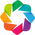

In [140]:
hv.extension("bokeh")

data = df_nasc_no_age1.copy()
lag_resolution=0.002
n_lags=30
coordinates=("x", "y")

etch = VariogramGUI(data, lag_resolution, n_lags, coordinates)

In [141]:
etch

In [ ]:
etch.variogram_model

In [98]:
D = {}

if not D:
    print("Not D!")

Not D!


In [ ]:
import panel as pn
import holoviews as hv

# Enable the Panel extension
pn.extension()

# 1. Create a selection panel widget
selection_panel = pn.widgets.Select(
        name="Variogram model",
        options=["Exponential", "Power law", "Bessel-Exponential"],
        value="Exponential",
        width=300
    )

# 2. Create the tabs layout
# tabs = pn.Tabs(("Dashboard", pn.Column("Initial content")), ("Potato", pn.pane.Markdown("")))
tabs = pn.Tabs(("Dashboard", pn.Column("Initial content")))

# 3. Define a function that returns new widgets based on the selection
# def get_dynamic_widgets(selected_type):
#     if selected_type == 'IntSlider':
#         return pn.widgets.IntSlider(name='Integer Slider', start=0, end=100)
#     elif selected_type == 'FloatSlider':
#         return pn.widgets.FloatSlider(name='Float Slider', start=0.0, end=1.0)
#     return pn.pane.Markdown("Please make a selection.")

def get_model_parameters(selected_model):
    model_name = VARIOGRAM_MODEL_PARAMETER_MAP.get(selected_model)
    args, func = get_variogram_arguments(model_name)
    params = list(p for p in dict(args) if p != "distance_lags")
    
    return pn.Column(
        *(
            pn.widgets.FloatInput(
                name=DEFAULT_VARIOGRAM_PARAMETERS.get(p)["name"], 
                value=DEFAULT_VARIOGRAM_PARAMETERS.get(p)["value"], 
                start=DEFAULT_VARIOGRAM_PARAMETERS.get(p)["min"], 
                end=DEFAULT_VARIOGRAM_PARAMETERS.get(p)["max"], 
                step=DEFAULT_VARIOGRAM_PARAMETERS.get(p)["step"])
            for p in params
        )
    )

# 4. Use pn.bind() to connect the selection widget to the function
dynamic_widgets = pn.bind(get_model_parameters, selected_model=selection_panel)

# 5. Add the selection widget and the dynamically bound output to the tab
# To display the dynamically generated content inside a specific tab,
# update the content of that tab's layout.
dashboard_content = pn.Column(
    '### Dynamic Widgets',
    selection_panel,
    dynamic_widgets
)

# Replace the 'Dashboard' tab content with the new layout
tabs[0].objects[0] = dashboard_content

# Display the final application
tabs.servable()


In [29]:
xs = [0.1* i for i in range(100)]
curve =  hv.Curve((xs, [np.sin(x) for x in xs]))
scatter =  hv.Scatter((xs[::5], np.linspace(0,1,20)))
heatmap = None

In [30]:
heatmap * curve + scatter

TypeError: unsupported operand type(s) for *: 'NoneType' and 'Curve'

In [21]:
curve * scatter * heatmap

AttributeError: 'Div' object has no attribute 'extents'

:Overlay
   .Curve.I   :Curve   [x]   (y)
   .Scatter.I :Scatter   [x]   (y)
   .Div.I     :Div

In [156]:
import markdown
import ipywidgets as ipw
import threading
import time
from lmfit import Parameters
from IPython.display import clear_output, display
from typing import Optional
from echopop.nwfsc_feat.variogram import Variogram
from echopop.nwfsc_feat.variogram_models import get_variogram_arguments, variogram
import traceback
import holoviews as hv
import pandas as pd
from bokeh.models import HoverTool

# ==================================================================================================
# Constants, mappings, and helper functions API
# ---------------------------------------------
# Vertical spacer
VSPACER = ipw.Box(layout=ipw.Layout(height='10px'))

# Variogram variable mapping
VARIABLE_MAP = {
    "Number density (animals nmi^-2)": "number_density", 
    "Biomass density (kg nmi^-2)": "biomass_density", 
    "NASC (m^2 nmi^-2)": "nasc",
}

# Variogram model mapping
VARIOGRAM_MODEL_PARAMETER_MAP = {
    "Bessel-Exponential": ["bessel", "exponential"],
    "Bessel-Gaussian": ["bessel", "gaussian"],
    "Cosine-Exponential": ["cosine", "exponential"],
    "Cosine-Gaussian": ["cosine", "gaussian"],
    "Cubic": "cubic",
    "Exponential": "exponential",
    "Exponential-Linear": ["exponential", "linear"],
    "Gaussian": "gaussian",
    "Gaussian-Linear": ["gaussian", "linear"],
    "J-Bessel": "jbessel",
    "K-Bessel": "kbessel",
    "Linear": "linear",
    "Matérn": "matern",
    "Nugget": "nugget",
    "Pentaspherical": "pentaspherical",
    "Power law": "power",
    "Rational quadratic": "quadratic",
    "Cardinal sine": "sinc",
    "Spherical": "spherical",
}

# Default parameter values mapping
DEFAULT_VARIOGRAM_PARAMETERS = {
    "correlation_range": {
        "name": "Correlation range (a)" ,
        "min": 1e-10, "value": 1.0, "max": 99999, "vary": False, "step": 1.0
    },
    "decay_power": {
        "name": "Decay power (\u03B1)",
        "min": 1e-10, "value": 1.0, "max": 2.0, "vary": False, "step": 0.1
    },
    "enhance_semivariance": {
        "name": "Enhance semivariance", 
        "value": True
    },
    "hole_effect_range": {
        "name": "Hole effect range (a\u2095)",
        "min": 0.0, "value": 0.0, "max": 99999, "vary": False, "step": 1.0
    },
    "sill": {
        "name": "Sill (C)",
        "min": 1e-10, "value": 1.0, "max": 99999, "vary": False, "step": 1.0
    },
    "nugget": {
        "name": "Nugget (C\u2080)",
        "min": 0.0, "value": 0.0, "max": 99999, "vary": False, "step": 1.0
    },
    "smoothness_parameter": {
        "name": "Matérn shape parameter (\u03BD)",
        "min": 0.0, "value": 0.5, "max": 10.0, "vary": False, "step": 0.1
    },
    "shape_parameter": {
        "name": "Scale (\u03B2)",
        "min": 1e-10, "value": 1.0, "max": 100.0, "vary": False, "step": 1.0
    },
    "power_exponent": {
        "name": "Power (\u03c9)",
        "min": 1e-10, "value": 1.0, "max": 2.0 - 1e-10, "vary": False, "step": 0.1
    }
}

def md_to_HTML(
    text: str, ipywidget_obj: Optional[ipw.HTML] = None,
):
    """
    Helper function that converts text and regular expressions from a markdown format to a 
    `ipywidgets.HTML` text object. When an `ipywidgets.HTML` object is supplied, then the text is 
    stored directly into the 'value' attribute of that object.
    """
    
    if ipywidget_obj:
        ipywidget_obj.value = markdown.markdown(text)
    else:  
        return ipw.HTML(value=markdown.markdown(text))

# ==================================================================================================
# Instructions tab
# ----------------
instructions_text = """
# Variogram Analysis Interactive GUI

## Overview
This interactive tool allows you to perform comprehensive variogram analysis with the following steps:

## Workflow

### Tab 2: Object Initialization
- Set the **lag resolution** and **number of lags** for the variogram analysis
- These parameters control the spatial resolution and extent of the analysis

### Tab 3: Compute Empirical Variogram
- Select the variable to analyze
- Configure azimuth filtering options
- Generate an interactive plot showing:
    - X-axis: Lag distance
    - Y-axis: Semivariance (γ)
    - Point size: Varies with lag count
    - Hover tooltips: Lag #, lag counts, and semivariance values

### Tab 4: Fit Theoretical Model
- Choose from available variogram models
- Parameters dynamically update based on selected model
- Black line shows theoretical fit on empirical plot

### Tab 5: Optimization
- Specify optimization parameters as dictionary
- Set parameter bounds and variation flags
- Red line shows optimized fit
- Display best-fit parameters with appropriate rounding

## Usage Notes
- Make sure to load your data before proceeding
- Each tab builds upon the previous steps
- Results can be saved for further analysis
"""

# Convert to ipywidgets
INSTRUCTIONS_TAB = ipw.VBox([md_to_HTML(instructions_text)])

# ==================================================================================================
# VariogramGUI class
# ------------------

class VariogramGUI:
    
    def __init__(
        self, data, lag_resolution, n_lags, coordinates, variogram_parameters: dict = {}
    ):
        
        # Initialize extension
        hv.extension("bokeh")
        
        # Store data/metadata attributes
        self.data = data
        
        # Initialize container for `Variogram` object
        self.vgm = None
        
        # Store the initialized values
        self.initialization_args = dict(
            lag_resolution=lag_resolution,
            n_lags=n_lags,
            coordinates=coordinates
        )
        
        # Store input variogram parameters that will be used as defaults
        self.variogram_parameters = variogram_parameters
        
        # Initialize the `lmfit.Parameters` and parameter widgets attributes
        self.parameters_lmfit = Parameters()
        
        # Initialize the input widgets for GUI initialization
        self.initialization_widgets = {}
        
        # Initialize the parameter widget dictionary for dynamic parameter mapping
        self.parameter_widgets = {}
        
        # Initialize the plotting area
        self.plot_output = ipw.Output(
            layout=ipw.Layout(
                border="1px solid black",
                width="800px",
                height="500px"
            )
        )
        # ---- Plot state management
        self.plot_layers = {
            'empirical': None,
            'theoretical': None, 
            'optimized': None
        }
        self.empirical_results = {}
        self.theoretical_results = {}
        self.optimization_results = {}
        
        # Initialize the status pane
        self.status_pane = ipw.HTML(value="")
        
        # Set up the GUI
        self._setup_gui()
    
    def _setup_gui(self):
        """
        Generate the tabs and overall display for the GUI. These will create both the general 
        tabs for each component as well as storing each tab as individual attributes for 
        debugging purposes.
        """
        
        # Instructions tab [TAB 1]
        self.instructions_tab = INSTRUCTIONS_TAB
        
        # Initialization tab [TAB 2]
        self.initialization_var_tab = self.initialize_tab()
        
        # Empirical variogram tab [TAB 3]
        self.empirical_var_tab = self.empirical_tab()
        
        # Initial variogram model tab [TAB 4]
        self.theoretical_var_tab = self.theoretical_tab()
        
        # Create tabs widget
        # self.tabs = ipw.Tab(
        control_tabs = ipw.Accordion(
            children=[
                self.instructions_tab,
                self.initialization_var_tab,
                self.empirical_var_tab,
                self.theoretical_var_tab,
            ]
        )
        
        # Set which section is open by default
        control_tabs.selected_index = None
        
        # Update the tab names
        # self.tabs.titles = ("Instructions", "Initialize variogram", "Empirical variogram", 
        #                     "Variogram model")
        control_tabs.titles = ("Instructions", "Initialize variogram", "Empirical variogram", 
                               "Variogram model")
        
        # MAIN
        self.tabs = ipw.HBox([
            ipw.VBox([control_tabs, self.status_pane], layout=ipw.Layout(width="450px")),
            self.plot_output
        ], layout=ipw.Layout(width="100%"))
        
    def _ipython_display_(self):
        """
        Integrate GUI into IPython without needing to create a separate property or 'get' 
        method. This enables the usage of just `VariogramGUI(...)` to instantiate a session. 
        """
        display(self.tabs)
        
    def _clear_plot(self):
        """
        Clear the plotting pane
        """
        # Clear the output
        with self.plot_output:
            clear_output(wait=True)
            
        # Reset all plot layers
        for key in self.plot_layers:
            self.plot_layers[key] = None

    def _clear_downstream_layers(self, from_layer):
        """
        Clear all layers after a given layer in the hierarchy.
        """
        
        # Get the layer order
        layer_order = list(self.plot_layers.keys())
        
        # Clear downstream
        if from_layer in layer_order:
            start_idx = layer_order.index(from_layer) + 1
            for layer in layer_order[start_idx:]:
                self.plot_layers[layer] = None
            
    def _update_plot_display(self):
        """
        Update the plot displayed based on the current plot state.
        """
        
        with self.plot_output:
            # Clear the plot
            clear_output(wait=True)
            
            # Get all non-None plot layers in order
            active_plots = [plot for plot in self.plot_layers.values() if plot is not None]
            md_to_HTML(ipywidget_obj=self.status_pane,
                       text=f"DEBUG: Found {len(active_plots)} active plots")  # ADD THIS
            
            # Update plot, if any
            if active_plots:
                # ---- Update overlay
                overlay = hv.Overlay(active_plots).opts(
                    hv.opts.Overlay(legend_position="bottom_right")
                )
                # ---- Create dynamic mapper
                self.overlay_dmap = hv.DynamicMap(lambda: overlay)
                # ---- Display
                display(self.overlay_dmap)
                
    def _update_model_parameters(self, change):
        """
        Dynamically update the displayed variogram model parameter widgets.
        """
        
        # Get the new model name
        model_name = change["new"]
        
        # Clear all preexisting parameter widgets
        self.parameter_widgets.clear()
        
        # Refresh the widgets
        with self.parameter_output:
            # ---- Clear
            clear_output(wait=True)
            try:
                # ---- Map the model function
                model = VARIOGRAM_MODEL_PARAMETER_MAP.get(model_name)
                # ---- Get the function signature
                args, _ = get_variogram_arguments(model)
                # ---- Store the model function name
                self.variogram_model = model
                # ---- Extract the parameters
                params = list(p for p in dict(args) if p != "distance_lags")
                # ---- Update the widgets
                for p in params:
                    # ---- Get defaults
                    defaults = DEFAULT_VARIOGRAM_PARAMETERS.get(p, {})
                    # ---- Grab user values
                    user = self.variogram_parameters.get(p, {})     
                    # ---- Combine
                    param_info = {**defaults, **user}
                    # ---- Missing parameter? Skip.
                    if not param_info:
                        continue
                    # ---- Generate label
                    param_label = md_to_HTML(f"**{param_info.get('name', p)}**")
                    # ---- Boolean -> Checkbox
                    if isinstance(param_info["value"], bool):
                        param_widget = ipw.Checkbox(
                            value=param_info["value"],
                        )               
                    # ---- Float -> BoundedFloatText
                    else:
                        param_widget = ipw.BoundedFloatText(
                            value=param_info["value"],
                            min=param_info.get("min"),
                            max=param_info.get("max"),
                            step=param_info.get("step"),                     
                        )
                    # ---- Update the parameter widget state
                    self.parameter_widgets[p] = param_widget
                    # ---- Consolidate the full widget
                    widget = ipw.VBox([param_label, param_widget], layout=ipw.Layout(width="200px"))
                    # ---- Display
                    display(widget)
                # ---- Update status pane
                md_to_HTML(
                    ipywidget_obj=self.status_pane,
                    text=f"**Status:** Updated {len(params)} parameters for {model_name}."
                )
            except Exception as e:
                # ---- Update status pane
                md_to_HTML(
                    ipywidget_obj=self.status_pane,
                    text=(
                        f"**Error:** Variogram model could not be computed due to the following "
                        f"error: {str(e)}."
                        f"\n  \n**Traceback:**  \n```  \n{traceback.format_exc()}  \n```"
                    )
                )                  
                
    def initialize_tab(self):
        """
        Tab for initializing the empirical variogram calculation. This allows for overriding 
        the initial inputs for 'n_lags' and 'lag_resolution'. The column names defined via 
        'coordinates' remain static. 
        """
        
        # Input widgets
        # ---- Lag resolution
        lag_resolution_input = ipw.BoundedFloatText(
            value=self.initialization_args["lag_resolution"],
            min=1e-10, max=1e99,
            step=self.initialization_args["lag_resolution"] * 1e-1,
            layout=ipw.Layout(width="300px")
        )
        # ---- Number of lags
        n_lags_input = ipw.BoundedIntText(
            value=self.initialization_args["n_lags"],
            min=2, max=int(1e99),
            step=1,
            layout=ipw.Layout(width="300px")
        )
        
        # Coordinates text pane
        coord_info = md_to_HTML(
            f"**Coordinate names:** {self.initialization_args["coordinates"]}"
        )
        
        # Update the widgets container
        self.initialization_widgets.update({
            "lag_resolution": lag_resolution_input,
            "n_lags": n_lags_input
        })
        
        # Initializion button
        initialize_button = ipw.Button(
            description="Initialize variogram",
            button_style="primary",
            layout=ipw.Layout(width="300px")
        )
        # ---- Set click interaction
        initialize_button.on_click(self.initialize_variogram)
        
        return ipw.VBox([
            ipw.VBox([md_to_HTML("**Lag resolution**"), lag_resolution_input]),
            ipw.VBox([md_to_HTML("**Number of lags**"), n_lags_input]),
            coord_info,
            VSPACER,
            initialize_button,
        ])
            
        # # Format the UI column
        # ui_column = ipw.VBox([
        #     ipw.VBox([md_to_HTML("**Lag resolution**"), lag_resolution_input]),
        #     ipw.VBox([md_to_HTML("**Number of lags**"), n_lags_input]),
        #     coord_info,
        #     VSPACER,
        #     initialize_button,
        # ], layout=ipw.Layout(width="450px"))
        
        # # Incorporate the plotting area and status pane
        # tab_output = ipw.VBox([
        #     ipw.HBox([ui_column, self.plot_output], layout=ipw.Layout(width="100%")),
        #     self.status_pane                
        # ])
        
        # # Return
        # return tab_output
        
    def initialize_variogram(self, button):
        """
        When the variogram initializatio button is clicked, a `Variogram`-class instance will 
        be initialized that enables downstream empirical and theoretical variogram computations.
        """
        
        try:                
            # Get entered inputs
            lag_resolution = self.initialization_widgets["lag_resolution"].value
            n_lags = self.initialization_widgets["n_lags"].value
            
            # Create new `Variogram`-class instance
            self.vgm = Variogram(
                lag_resolution=lag_resolution,
                n_lags=n_lags,
                coordinate_names=self.initialization_args["coordinates"],
            )
            
            # Reset the plotting state 
            self._clear_plot()
            self.empirical_results.clear()
            
            # Update the status pane
            md_to_HTML(
                ipywidget_obj=self.status_pane,
                text=(
                    f"**Status**: Variogram initialized  \nLag resolution: {lag_resolution}  \n"
                    f"Number of lags: {n_lags}"
                )
            )            
        except Exception as e:                
            # Update the status pane
            md_to_HTML(
                ipywidget_obj=self.status_pane,
                text=(
                    f"**Error:** Failed to initialize the variogram due to the following "
                    f"error: {str(e)}. "
                    f"\n  \n**Traceback:**  \n```  \n{traceback.format_exc()}  \n```"
                )
            )
    
    def empirical_tab(self):
        """
        Tab for calculating and visualizing the empirical variogram based on user inputs. 
        """
        
        # Input widgets
        # ---- Variable selection
        variable_select = ipw.Dropdown(
            options=list(VARIABLE_MAP.keys()),
            value="Biomass density (kg nmi^-2)",
            layout=ipw.Layout(width="300px")
        )
        # ---- Azimuth filter
        # -------- Set up boolean activation first 
        azimuth_filter = ipw.Checkbox(value=True)
        # -------- Define threshold widget
        azimuth_threshold = ipw.BoundedFloatText(
            value=180.0, min=0.0, max=180.0, step=1.0, layout=ipw.Layout(width="300px")
        )
        # -------- Create helper function for toggling the float text accessibility
        def toggle_azimuth_threshold(change):
            azimuth_threshold.disabled = not change.new
        # -------- Set up observer
        azimuth_filter.observe(toggle_azimuth_threshold, names="value")
        # -------- Hard-code default for filter
        azimuth_threshold.disabled = not azimuth_filter.value
        
        # Store widgets for callback access
        self.empirical_widgets = {
            "variable": variable_select,
            "azimuth_filter": azimuth_filter,
            "azimuth_threshold": azimuth_threshold,
        }
        
        # Computation button
        computation_button = ipw.Button(
            description="Compute empirical variogram",
            button_style="primary",
            layout=ipw.Layout(width="300px")
        )
        # ---- Set click interaction
        computation_button.on_click(self.empirical_variogram)
        
        return ipw.VBox([
            md_to_HTML("**Empirical variogram settings**"),
            ipw.VBox([md_to_HTML("**Variable**"), variable_select]),
            ipw.VBox([
                md_to_HTML("**Azimuth filter** (*check box to apply filter*)"),
                ipw.HBox([azimuth_filter, azimuth_threshold])                
            ]),
            VSPACER,
            computation_button
        ])
            
        # Format the UI column
        # ui_column = ipw.VBox([
        #     md_to_HTML("**Empirical variogram settings**"),
        #     ipw.VBox([md_to_HTML("**Variable**"), variable_select]),
        #     ipw.VBox([
        #         md_to_HTML("**Azimuth filter** (*check box to apply filter*)"),
        #         ipw.HBox([azimuth_filter, azimuth_threshold])                
        #     ]),
        #     VSPACER,
        #     computation_button
        # ], layout = ipw.Layout(width="450px"))
        
        # # Incorporate the plotting area and status pane
        # tab_output = ipw.VBox([
        #     ipw.HBox([ui_column, self.plot_output], layout=ipw.Layout(width="100%")),
        #     self.status_pane                
        # ])
        
        # Return
        # return tab_output
        
    def empirical_variogram(self, button):
        """
        Calculate the empirical variogram using the updated widget inputs.
        """
        
        try:
            # Check for initialized `Variogram`-class
            if self.vgm is None:
                md_to_HTML(
                    ipywidget_obj=self.status_pane,
                    text=(
                        "**Error:** Variogram has not been initialized. Initialize the variogram "
                        "in the 'Initialization' tab before proceeding."
                    )
                )
                return
            
            # Check for input dataset
            if self.data is None:
                md_to_HTML(
                    ipywidget_obj=self.status_pane,
                    text=(
                        "**Error:** No dataset provided for variogram computation."
                    )
                )                
                
            # Extract the empirical variogram parameters
            variable = VARIABLE_MAP[self.empirical_widgets["variable"].value]
            azimuth_filter = self.empirical_widgets["azimuth_filter"].value
            azimuth_threshold = self.empirical_widgets["azimuth_threshold"].value
            
            # Compute the empirical variogram
            # ---- Update status pane
            md_to_HTML(
                ipywidget_obj=self.status_pane,
                text=(
                    "**Status:** Computing empirical variogram..."
                )
            )         
            # ---- Compute
            self.vgm.calculate_empirical_variogram(
                data=self.data, variable=variable, azimuth_filter=azimuth_filter, 
                azimuth_angle_threshold=azimuth_threshold
            )      
            
            # Extract results
            lags = self.vgm.lags
            gamma = self.vgm.gamma
            lag_counts = self.vgm.lag_counts
            
            # Update the empirical results container
            self.empirical_results = {
                "lags": lags,
                "gamma": gamma,
                "lag_counts": lag_counts,
            }    
            
            # Update status pane
            md_to_HTML(
                ipywidget_obj=self.status_pane,
                text=(
                    f"**Status:** Empirical variogram computation complete. "
                    f"[{self.empirical_widgets["variable"].value}, *n*={len(lags)} lags]"
                )
            )   
            
            # Render the plot 
            # ---- Store empirical variogram plot
            self.plot_layers["empirical"] = self.plot_empirical_variogram()                        
            # ---- Clear the current plot state
            self._clear_downstream_layers("empirical")   
            # ---- Update the plot display
            self._update_plot_display()     
        
        except Exception as e:      
            # Update status panel
            md_to_HTML(
                ipywidget_obj=self.status_pane,
                text=(
                    f"**Error:** Empirical variogram could not be computed due to the following "
                    f"error: {str(e)}."
                    f"\n  \n**Traceback:**  \n```  \n{traceback.format_exc()}  \n```"
                )
            )       
            
    def plot_empirical_variogram(self):
        """
        Plot the empirical variogram. This is a scatter plot at each defined lag distance where 
        the size of each point scales with the lag counts at each point. 
        """                  
        
        # Extract variables
        lags = self.empirical_results["lags"]
        gamma = self.empirical_results["gamma"]
        lag_counts = self.empirical_results["lag_counts"]
    
        # Create the required DataFrame for plotting
        plot_data = pd.DataFrame({
            "distance": lags, 
            "semivariance": gamma, 
            "lag_count": lag_counts, 
            "lag_number": range(1, len(lags) + 1)
        }) 
        
        # Scale point sizes based on lag counts
        if len(lag_counts) > 1 and lag_counts.max() > lag_counts.min():
            size_scale = lambda x: (((x - x.min()) / float(x.max() - x.min()) + 1) * 3) ** 2
            plot_data["point_size"] = size_scale(lag_counts)
        else:
            plot_data["point_size"] = 10
            
        # Create axis-style hook
        def style_axes(plot, element):
            for ax in [plot.state.xaxis[0], plot.state.yaxis[0]]:
                ax.axis_label_text_color = "black"
                ax.axis_label_text_font_size = "16pt"
                ax.axis_label_text_font_style = "normal"
                ax.major_label_text_color = "black"
                ax.major_label_text_font_size = "12pt"
        
        # Hover tooltip
        hover = HoverTool(
            tooltips=[
                ("Lag #", "@lag_number"),
                ("Distance", "@distance{0.000}"),
                ("Semivariance", "@semivariance{0.000}"),
                ("Count", "@lag_count")
            ]
        )          
        
        # Create the plot
        variogram_scatter = hv.Scatter(
            plot_data,
            kdims=["distance"],
            vdims=["semivariance", "lag_count", "lag_number", "point_size"]
        ).opts(
            size="point_size",
            color="blue",
            line_color="black",
            line_width=1,
            width=760,
            height=460,
            # xlabel="Lag distance [<i>h</i>]",
            xlabel=r"Lag distance [$$h$$]",
            ylabel=r"Semivariance [$$γ$$]",
            show_grid=True,
            tools=[hover, "pan", "wheel_zoom", "box_zoom", "reset"],
            active_tools=["pan"],
            default_tools=[],
            hooks=[style_axes]
        )
        
        # Return
        return variogram_scatter
    
    def theoretical_tab(self):
        """
        Tab for calculating and visualizing the initial theoretical variogram based on user inputs. 
        """
        
        # Initialize the Output container
        self.parameter_output = ipw.Output()
        
        # Input widgets
        # ---- Model selection
        model_selection = ipw.Dropdown(
            options=list(VARIOGRAM_MODEL_PARAMETER_MAP.keys()),
            value="Exponential",
            layout=ipw.Layout(width="300px")
        )
        # ---- Attach an observer
        model_selection.observe(self._update_model_parameters, names="value")
        # self._update_model_parameters({"new": model_selection.value})
        
        # Computation button
        computation_button = ipw.Button(
            description="Compute theoretical variogram",
            button_style="primary",
            layout=ipw.Layout(width="300px")
        )
        # ---- Set click interaction
        computation_button.on_click(self.theoretical_variogram)
        
        tab_output =  ipw.VBox([
            md_to_HTML("**Theoretical variogram model settings**"),
            ipw.VBox([md_to_HTML("**Variogram model**"), model_selection]),
            self.parameter_output,
            VSPACER,
            computation_button
        ])
        
        # # Initialize the model parameter widgets
        # def delayed_init():
        #     time.sleep(0.1)
        #     self._update_model_parameters({"new": model_selection.value})
        # thread = threading.Thread(target=delayed_init)
        # thread.start()
        
        # # Format the UI column
        # ui_column = ipw.VBox([
        #     md_to_HTML("**Theoretical variogram model settings**"),
        #     ipw.VBox([md_to_HTML("**Variogram model**"), model_selection]),
        #     self.parameter_output,
        #     VSPACER,
        #     computation_button
        # ], layout = ipw.Layout(width="450px"))
        
        # # Incorporate the plotting area and status pane
        # tab_output = ipw.VBox([
        #     ipw.HBox([ui_column, self.plot_output], layout=ipw.Layout(width="100%")),
        #     self.status_pane                
        # ])
        
        # self._update_model_parameters({"new": model_selection.value})
        # FORCE THE INITIAL PARAMETER UPDATE AFTER A TINY DELAY
        def force_update():
            self._update_model_parameters({"new": "Exponential"})
        
        # Schedule the update using IPython's event loop
        model_selection.observe(lambda x: force_update(), names="value")
        # Trigger it immediately
        force_update()
        
        # # Return
        return tab_output
    
    def theoretical_variogram(self, button):
        """
        Compute the theoretical variogram using the updated widget inputs.
        """
        
        # Check for initialized `Variogram`-class
        if self.vgm is None:
            md_to_HTML(
                ipywidget_obj=self.status_pane,
                text=(
                    "**Error:** Variogram has not been initialized. Initialize the variogram "
                    "in the 'Initialization' tab before proceeding."
                )
            )
            return
        
        # Check for input dataset
        if self.data is None:
            md_to_HTML(
                ipywidget_obj=self.status_pane,
                text=(
                    "**Error:** No dataset provided for variogram computation."
                )
            )     
            
        # Check for empirical result
        if not self.empirical_results:
            md_to_HTML(
                ipywidget_obj=self.status_pane,
                text=(
                    "**Error:** You must compute the empirical variogram before running the "
                    "initial theoretical variogram model."
                )
            )       
            return
        
        
        try:     
            # Compute the initial variogram model fit
            # ---- Collect parameter widget inputs
            param_values = {p: w.value for p, w in self.parameter_widgets.items()}
            # ---- Compute the theoretical variogram
            gamma_model = variogram(
                model=self.variogram_model, 
                distance_lags=self.vgm.lags,
                variogram_parameters=param_values
            )
            
            # Update the initial theoretical model results container
            self.theoretical_results = {
                "lags": self.vgm.lags,
                "gamma": gamma_model,
            }    
            
            # Render the plot 
            # ---- Store empirical variogram plot
            self.plot_layers["theoretical"] = self.plot_theoretical_variogram()                        
            # ---- Clear the current plot state
            self._clear_downstream_layers("theoretical")   
            # ---- Update the plot display
            self._update_plot_display()    
            
        except Exception as e:      
            # Update status panel
            md_to_HTML(
                ipywidget_obj=self.status_pane,
                text=(
                    f"**Error:** Theoretical variogram model could not be computed due to the  "
                    f"following error: {str(e)}."
                    f"\n  \n**Traceback:**  \n```  \n{traceback.format_exc()}  \n```"
                )
            )     
            
    def plot_theoretical_variogram(self):
        """
        Plot the theoretical variogram. This is a line curve that fits the modeled semivariance 
        predictions to the empirical variogram domain.
        """   
        
        # Extract variables
        lags = self.theoretical_results["lags"]
        gamma = self.theoretical_results["gamma"]
    
        # Create the required DataFrame for plotting
        plot_data = pd.DataFrame({
            "distance": lags, 
            "semivariance": gamma, 
        }) 
        
        # Create line curve
        variogram_curve = hv.Curve(
            plot_data,
            kdims=["distance"],
            vdims=["semivariance"],
            label="Initial model fit"
        ).opts(
            color="black",
            line_width=2.5
        )
        
        # Return
        return variogram_curve
            
                

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
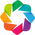

In [157]:
data = df_nasc_no_age1.copy()
lag_resolution=0.002
n_lags=30
coordinates=("x", "y")

etch2 = VariogramGUI(data, lag_resolution, n_lags, coordinates)

In [158]:
etch2

In [89]:
import numpy as np
import holoviews as hv

xs=np.arange(0,10)
ys=np.sin(xs)
hv.Curve((xs, ys)).opts(xlabel=r"Lag distance [$$h$$]")


:Curve   [x]   (y)